In [1]:
import matplotlib
matplotlib.use("TkAgg")
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import gym
from gym import wrappers, logger
import pandas as pd
import numpy as np
import random
import copy
import torch
from torch import nn
from torch import *
import torch.optim as optim
from torch.distributions import Categorical
from tqdm import tqdm_notebook as tqdm
import os,sys,inspect

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

from modules.utils import ReplayMemory, NeuralNet
from modules.A2C import A2CAgent
from modules.PPO import PPO

In [7]:
if __name__ == '__main__':

    ### hyper-parameters ###
    gamma = 0.99

    ### Environment setting ###
    #env_name = 'CartPole-v1'
    env_name = 'LunarLander-v2'
    env = gym.make(env_name)
    outdir = env_name + '/A2C-results'
    
    
    
    envm = wrappers.Monitor(env, directory=outdir, force=True, video_callable=False)
    env.seed(0)
    env.reset()
    done = False
    verbose = False
    
    batch_size = 10
    step_mem = ReplayMemory(batch_size=batch_size) ## saves trajectories steps
    batch_mem = ReplayMemory(batch_size=batch_size) ## saves batch trajectories
    
    action_size = env.action_space.n 
    state_size = env.observation_space.shape[0]
    layers_actor = [10, 10, 10]
    layers_critic = [10, 10, 10]
    
    
    
    update_freq = 10
    nb_updates = 10
    batch_size = 10  ## batch size of trajectories for updates < update_freq
    
    clip = False
    
    ### Initialization ### Actor + Critic
    a2c = A2CAgent(actor = NeuralNet(state_size, action_size, layers_actor).double(),
                   critic = NeuralNet(state_size, 1, layers_critic, soft=False).double())

    KL_penalty = 10.0
    KL_target = 0.001
    eps = .2
    
    ppo = PPO(a2c, KL_penalty, KL_target, eps, clip=clip)
    
    ### Training Settings ###
    episode_count = 4000
    optimizerActor = optim.Adam(ppo.model.actor.parameters())
    optimizerCritic = optim.Adam(ppo.model.critic.parameters())
    huberLoss = nn.SmoothL1Loss()

    rsum_hist = []

    ### Training loop ###
    t = tqdm(range(episode_count//update_freq), desc="Episod : rsum : iter :")

    for episode in t:
       
        for i in range(update_freq):
            
            it = 0
            obs = envm.reset()
            rsum = 0.0
            done = False
            
            while(True):

                if verbose == True:
                    env.render()

                state = obs
                action = ppo.model.act(state).detach()
                obs, reward, done, _ = envm.step(action.item())
                rsum += reward
                it += 1

                step_mem.store(state, action, reward, obs, done)

                if done == True:
                    t.set_description(desc="Episode :%d, rsum=%.2f, iter = %d"%(episode*update_freq +i, rsum, it), refresh=True)
                    t.refresh()
                    rsum_hist.append(rsum)
                    break  
                    
            #_batch_size = min([update_freq, batch_size, len(step_mem)])
            
            ## getting trajectory and erasing memory ##
            states, actions, rewards, obss, dones = step_mem.pop(batch_size=len(step_mem)) 
            step_mem.reset()
            
            ## storing trajectory ##
            batch_mem.store(states, actions, rewards, obss, dones)  
            
        ## getting batch of trajectories ##
        _batch_size = min([update_freq, batch_size])
        states, actions, rewards, obss, dones = batch_mem.pop(batch_size=_batch_size, stack=False) ## getting trajectory
        ppo.save_distprobs(states, actions) 
        
        for i in range(nb_updates):
            critic_loss, actor_loss = ppo.compute_loss(states, actions, rewards, obss, dones, gamma)

            ## critic loss ##
            optimizerCritic.zero_grad()
            critic_lossTrue.backward()
            optimizerCritic.step()

            ## actor loss ##
            optimizerActor.zero_grad()
            actor_loss.backward()
            optimizerActor.step()
        batch_mem.reset()

env.close()

/home/oussama/Desktop/M2A/RLDL/modules/utils.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  action = torch.stack([torch.tensor(exp.action) for exp in batch])
/home/oussama/Desktop/M2A/RLDL/modules/utils.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = [torch.tensor(exp.state) for exp in batch]
/home/oussama/Desktop/M2A/RLDL/modules/utils.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  action = [torch.tensor(exp.action) for exp in batch]
/home/oussama/Desktop/M2A/RLDL/modules/utils.py:47: UserWarning: To copy constru

KeyboardInterrupt: 

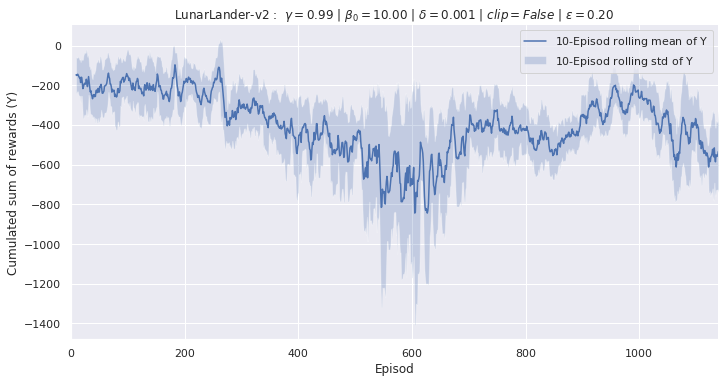

In [8]:
window = 10
data = pd.concat([pd.Series(rsum_hist, name='mean').rolling(window).mean(),
          pd.Series(rsum_hist, name='std').rolling(window).std()],
          axis=1)

sns.set()
plt.figure(figsize=(10,5))
ax = data['mean'].plot()

ax.fill_between(data.index, data['mean'] - data['std'], data['mean'] + data['std'],
                alpha=.25)
plt.tight_layout()
plt.ylabel("Cumulated sum of rewards (Y)")

title = r'%s :  $\gamma = %.2f$ | $\beta_{0} =%.2f$ | $\delta=%.3f$ | $ clip = %r$ | $\epsilon = %.2f$'%(env_name, gamma, KL_penalty, KL_target, clip, eps)
    
plt.title(title)

plt.legend(['$%d$-Episod rolling mean of Y'%window, '$%d$-Episod rolling std of Y'%window])
plt.xlabel('Episod')
sns.despine()
